In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

In [2]:
def generate_uniform(N):
    return np.random.uniform(-np.sqrt(3),np.sqrt(3),N)

def generate_normal(N):
    return np.random.normal(0, 1, N)

def generate_exp(N):
    return np.random.exponential(1, N)

# 1-2

In [3]:
import numpy as np

alpha = 0.05
n_samples = 1000
sample_size = 1000
all_k = {}

def count_outliers(sample_data, k):
    q1, q3 = np.percentile(sample_data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return sum((sample_data < lower_bound) | (sample_data > upper_bound))

for dist in [generate_normal, generate_uniform, generate_exp]:
    k_values = []
    outlier_densities = []
    k_range = np.linspace(0.5, 3.0, 100)

    for k in k_range:
        outliers_per_k = []

        sample_data = dist(sample_size)
        if dist.__name__ == 'generate_exp':
            sample_data = [d - 1 for d in sample_data]
        outliers = count_outliers(sample_data, k)
        outliers_per_k.append(outliers / sample_size)
        outlier_densities.append(outliers_per_k)

    k_optimal = k_range[np.argmin(np.abs(np.array(outlier_densities) - alpha))] 
    all_k[dist.__name__] = k_optimal

    print(f"Распределение: {dist.__name__}, оптимальное k = {k_optimal}")

Распределение: generate_normal, оптимальное k = 0.9797979797979798
Распределение: generate_uniform, оптимальное k = 0.5
Распределение: generate_exp, оптимальное k = 1.3838383838383839


In [4]:
crit_values = {'normal' : {}, 'uniform' : {}, 'exp' : {}}

alpha = 0.05
for dist in [generate_normal, generate_uniform, generate_exp]:
    print(f"Распределение: {dist.__name__.split('_')[1]}")
    for n in [10, 20, 50, 100, 200]:
        z_score = []
        modified_z_score = []
        boxplot_bounds = []
        k = all_k[dist.__name__]
        for _ in range(1000):
            data = sorted(dist(n))
            if dist.__name__ == 'generate_exp':
                data = [d - 1 for d in data]

            median = np.median(data)
            mean = np.mean(data)
            std_dev = np.sqrt(np.var(data, ddof=1))
            iqr = np.percentile(data, 75) - np.percentile(data, 25)
            
            z_score.append(np.percentile((data - mean) / std_dev, (1 - alpha) * 100))
            mad = np.median(np.abs(data - median))  # медианное абсолютное отклонение
            modified_z_score.append(0.6745 * (median - data[0]) / mad)

            #k = all_k[dist.__name__ + str(n)]
            lower_bound = np.percentile(data, 25) - k * iqr
            upper_bound = np.percentile(data, 75) + k * iqr
            boxplot_bounds.append((lower_bound, upper_bound))
            
        z_crit = np.percentile(np.abs(z_score), (1 - alpha/2) * 100)
        mod_z_crit = np.percentile(np.abs(modified_z_score), (1 - alpha/2) * 100)
        print(f"   n = {n}, z_crit = {z_crit}, mod_z_crit = {mod_z_crit}, boxplot: ({np.mean([bound[0] for bound in boxplot_bounds])}, {np.mean([bound[1] for bound in boxplot_bounds])})\n")
        crit_values[dist.__name__.split('_')[1]][n] = [z_crit, mod_z_crit, (np.mean([bound[0] for bound in boxplot_bounds]), np.mean([bound[1] for bound in boxplot_bounds]))]

Распределение: normal
   n = 10, z_crit = 1.669282442445301, mod_z_crit = 4.305950517633591, boxplot: (-1.7224015680606355, 1.7267548503975647)

   n = 20, z_crit = 1.9357584288789107, mod_z_crit = 4.285146764096193, boxplot: (-1.8599857753675388, 1.871952391269661)

   n = 50, z_crit = 1.867079168182908, mod_z_crit = 3.7948095337976375, boxplot: (-1.9431289489454648, 1.9453685805668532)

   n = 100, z_crit = 1.8768062987079503, mod_z_crit = 3.8429825440089505, boxplot: (-1.9668896872251826, 1.9640351609354434)

   n = 200, z_crit = 1.819788923019345, mod_z_crit = 3.829144638874023, boxplot: (-1.9842062344571796, 1.9779327595353322)

Распределение: uniform
   n = 10, z_crit = 1.6539998054624532, mod_z_crit = 3.887380545886694, boxplot: (-1.4132890981875126, 1.3922022153038753)

   n = 20, z_crit = 1.834518288358794, mod_z_crit = 2.7757104854638968, boxplot: (-1.5595073207514911, 1.5689760771826273)

   n = 50, z_crit = 1.784050484721083, mod_z_crit = 2.0657815586537325, boxplot: (-1.65

# 3

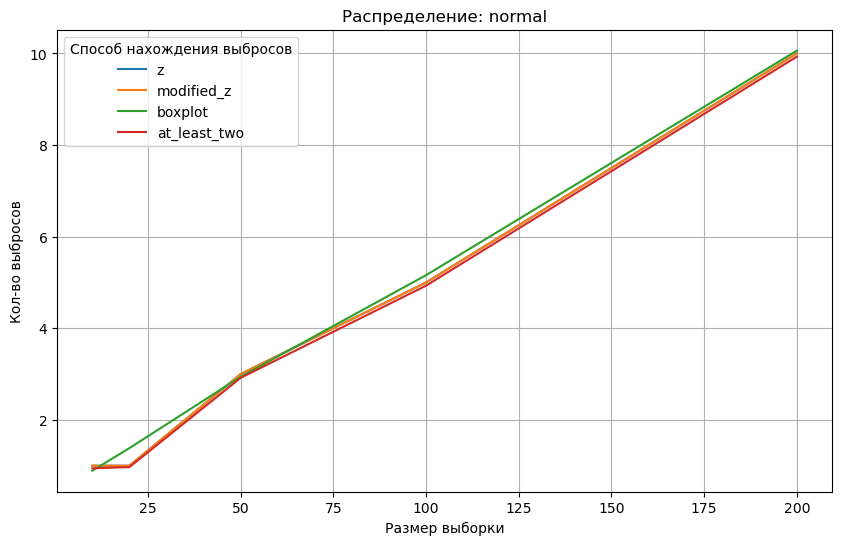

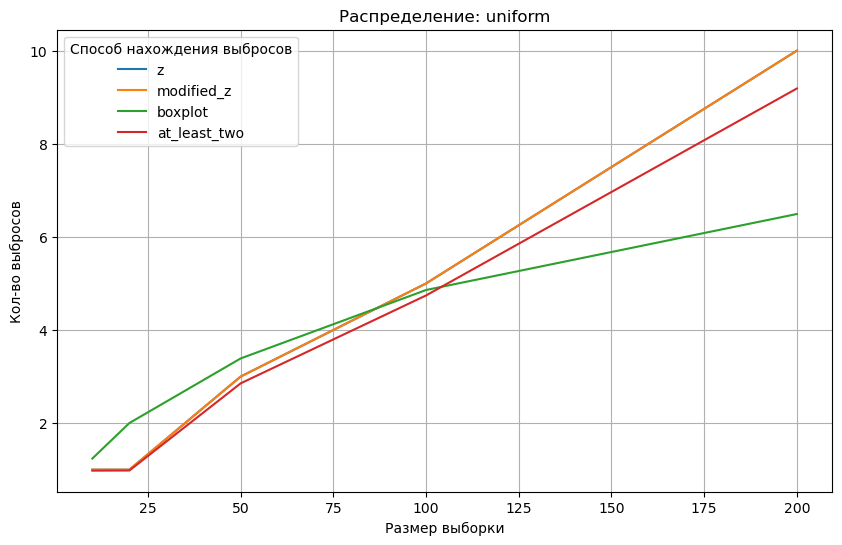

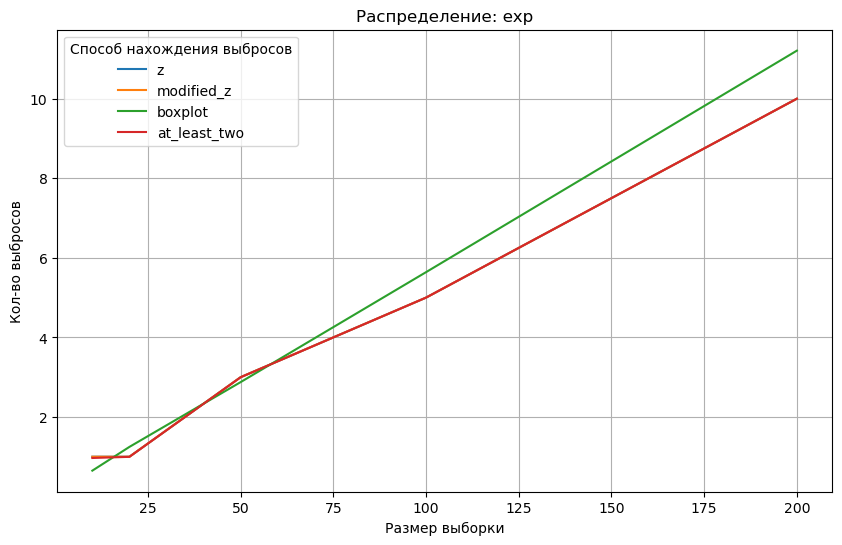

In [17]:
crit_values = {'normal' : {}, 'uniform' : {}, 'exp' : {}}

alpha = 0.05
for dist in [generate_normal, generate_uniform, generate_exp]:
    outlier_counts = {
        'z': [],
        'modified_z': [],
        'boxplot': [],
        'at_least_two': []
    }
    dist_name = dist.__name__.split('_')[1]
    for n in [10, 20, 50, 100, 200]:
        k = all_k[dist.__name__]
        outlier_counts_curn = {
            'z': [],
            'modified_z': [],
            'boxplot': [],
            'at_least_two': []
        }
        for _ in range(1000):
            data = sorted(dist(n))
            if dist.__name__ == 'generate_exp':
                data = [d - 1 for d in data]

            median = np.median(data)
            mean = np.mean(data)
            std_dev = np.sqrt(np.var(data, ddof=1))
            iqr = np.percentile(data, 75) - np.percentile(data, 25)

            z_score = np.abs((data - mean) / std_dev)
            z_crit = np.percentile(z_score, (1 - alpha) * 100)
            mad = np.median(np.abs(data - median))  # медианное абсолютное отклонение
            z_mod = np.abs(0.6745 * (data - median) / mad)
            z_mod_crit = np.percentile(z_mod, (1 - alpha) * 100)

            lower_bound = np.percentile(data, 25) - k * iqr
            upper_bound = np.percentile(data, 75) + k * iqr

            outliers_z = [x for x in data if abs((x - mean) / std_dev) > abs(z_crit)]
            outliers_modified_z = [x for x in data if abs(0.6745 * (x - median) / mad) > abs(z_mod_crit)]
            outliers_boxplot = [x for x in data if x < lower_bound or x > upper_bound]
    
            # Подсчет выбросов хотя бы по двум подходам
            outliers_combined = (set(outliers_z) & set(outliers_modified_z)) | \
                        (set(outliers_z) & set(outliers_boxplot)) | \
                        (set(outliers_modified_z) & set(outliers_boxplot))
    
            
            outlier_counts_curn['z'].append(len(outliers_z))
            outlier_counts_curn['modified_z'].append(len(outliers_modified_z))
            outlier_counts_curn['boxplot'].append(len(outliers_boxplot))
            outlier_counts_curn['at_least_two'].append(len(outliers_combined))

        outlier_counts['z'].append(np.mean(outlier_counts_curn['z']))
        outlier_counts['modified_z'].append(np.mean(outlier_counts_curn['modified_z']))
        outlier_counts['boxplot'].append(np.mean(outlier_counts_curn['boxplot']))
        outlier_counts['at_least_two'].append(np.mean(outlier_counts_curn['at_least_two']))

    plt.figure(figsize=(10, 6))
    plt.grid(True)

    for method in outlier_counts:
        plt.plot([10, 20, 50, 100, 200], outlier_counts[method], label=method)

    plt.title(f"Распределение: {dist_name}")
    plt.xlabel("Размер выборки")
    plt.ylabel("Кол-во выбросов")
    plt.legend(title="Способ нахождения выбросов")
    plt.show()
    plt.close()

# ДЗ

In [23]:
from sklearn.cluster import DBSCAN

data = generate_normal(10)

dbscan = DBSCAN()

model = dbscan.fit(data[:, np.newaxis])

labels = model.labels_
(labels==-1).sum()

4

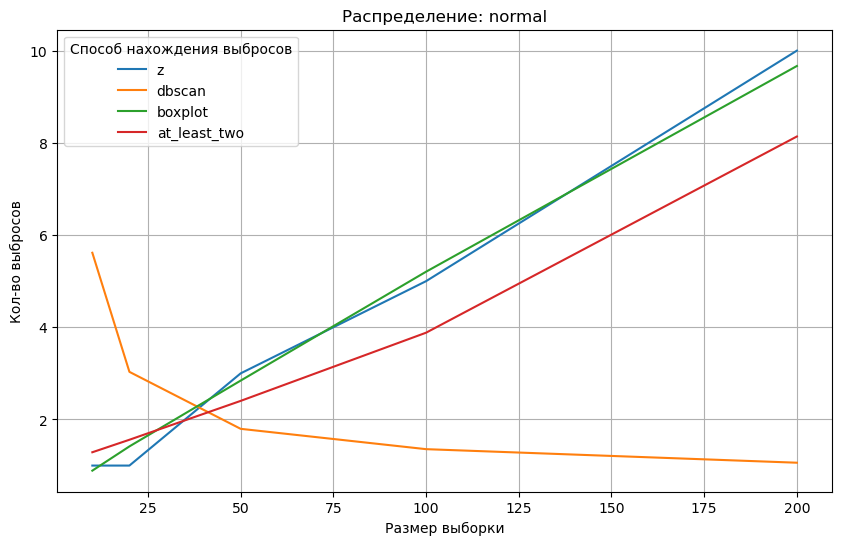

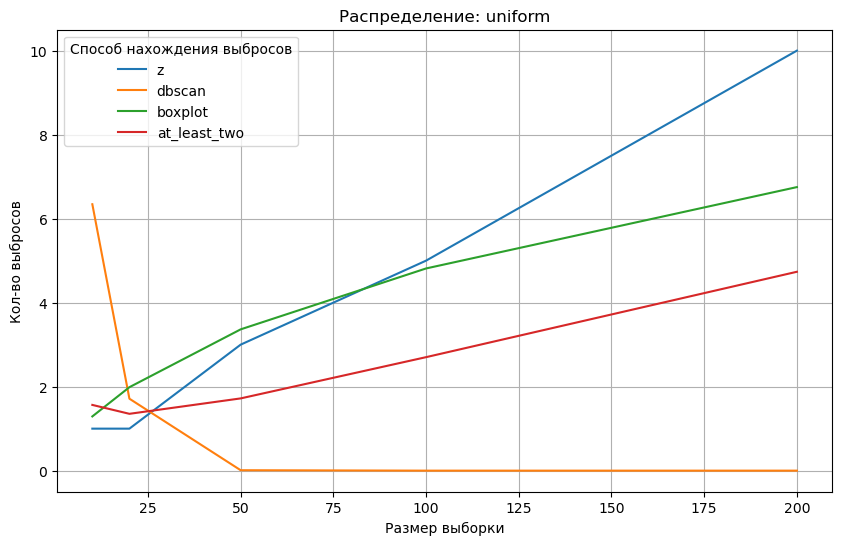

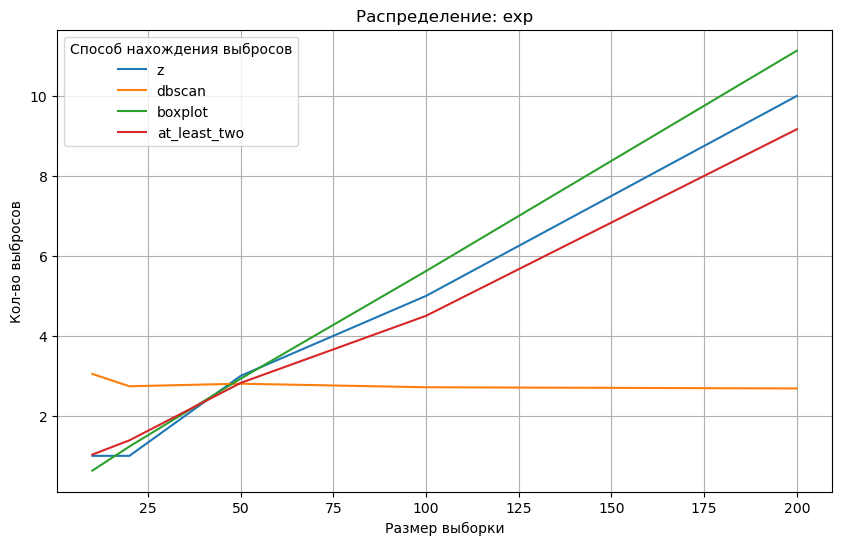

In [26]:
crit_values = {'normal' : {}, 'uniform' : {}, 'exp' : {}}

alpha = 0.05
for dist in [generate_normal, generate_uniform, generate_exp]:
    outlier_counts = {
        'z': [],
        'dbscan': [],
        'boxplot': [],
        'at_least_two': []
    }
    dist_name = dist.__name__.split('_')[1]
    for n in [10, 20, 50, 100, 200]:
        k = all_k[dist.__name__]
        outlier_counts_curn = {
            'z': [],
            'dbscan': [],
            'boxplot': [],
            'at_least_two': []
        }
        for _ in range(1000):
            data = sorted(dist(n))
            if dist.__name__ == 'generate_exp':
                data = [d - 1 for d in data]

            mean = np.mean(data)
            std_dev = np.sqrt(np.var(data, ddof=1))
            iqr = np.percentile(data, 75) - np.percentile(data, 25)

            z_score = np.abs((data - mean) / std_dev)
            z_crit = np.percentile(z_score, (1 - alpha) * 100)
            model = dbscan.fit(np.array(data)[:, np.newaxis])
            labels = model.labels_

            lower_bound = np.percentile(data, 25) - k * iqr
            upper_bound = np.percentile(data, 75) + k * iqr

            outliers_z = [x for x in data if abs((x - mean) / std_dev) > abs(z_crit)]
            outliers_dbscan = [data[i] for i in range(n) if labels[i] == -1]
            outliers_boxplot = [x for x in data if x < lower_bound or x > upper_bound]
    
            # Подсчет выбросов хотя бы по двум подходам
            outliers_combined = (set(outliers_z) & set(outliers_dbscan)) | \
                        (set(outliers_z) & set(outliers_boxplot)) | \
                        (set(outliers_dbscan) & set(outliers_boxplot))
    
            
            outlier_counts_curn['z'].append(len(outliers_z))
            outlier_counts_curn['dbscan'].append(len(outliers_dbscan))
            outlier_counts_curn['boxplot'].append(len(outliers_boxplot))
            outlier_counts_curn['at_least_two'].append(len(outliers_combined))

        outlier_counts['z'].append(np.mean(outlier_counts_curn['z']))
        outlier_counts['dbscan'].append(np.mean(outlier_counts_curn['dbscan']))
        outlier_counts['boxplot'].append(np.mean(outlier_counts_curn['boxplot']))
        outlier_counts['at_least_two'].append(np.mean(outlier_counts_curn['at_least_two']))

    plt.figure(figsize=(10, 6))
    plt.grid(True)

    for method in outlier_counts:
        plt.plot([10, 20, 50, 100, 200], outlier_counts[method], label=method)

    plt.title(f"Распределение: {dist_name}")
    plt.xlabel("Размер выборки")
    plt.ylabel("Кол-во выбросов")
    plt.legend(title="Способ нахождения выбросов")
    plt.show()
    plt.close()